Based on:

Basic Tutorial - fairmodels
http://fairmodels.drwhy.ai/articles/Basic_tutorial.html



For this tutorial we will use compas data to see if someone will become recidivist in next 2 years.
We will use modified ProPublica’s compas data to represent our problem.

In [1]:
library(fairmodels)
library(DALEX)
library(ranger)

Welcome to DALEX (version: 2.2.0).
Find examples and detailed introduction at: http://ema.drwhy.ai/
Additional features will be available after installation of: ggpubr.
Use 'install_dependencies()' to get all suggested dependencies



In [2]:
data("compas")

head(compas)

,Two_yr_Recidivism,Number_of_Priors,Age_Above_FourtyFive,Age_Below_TwentyFive,Misdemeanor,Ethnicity,Sex
,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>
1,0,0,1,0,0,Other,Male
2,1,0,0,0,0,African_American,Male
3,1,4,0,1,0,African_American,Male
4,0,0,0,0,1,Other,Male
5,1,14,0,0,0,Caucasian,Male
6,0,3,0,0,0,Other,Male


In [3]:
compas$Two_yr_Recidivism <- as.factor(ifelse(compas$Two_yr_Recidivism == '1', '0', '1'))

We train a ranger model and create an explainer with DALEX.

In [4]:
# train
rf_compas <- ranger(Two_yr_Recidivism ~., data = compas, probability = TRUE)

# numeric target values
y_numeric <- as.numeric(compas$Two_yr_Recidivism)-1

# explainer
rf_explainer <- explain(rf_compas, data = compas[,-1], y = y_numeric, colorize = FALSE)

Preparation of a new explainer is initiated
  -> model label       :  ranger  (  default  )
  -> data              :  6172  rows  6  cols 
  -> target variable   :  6172  values 
  -> predict function  :  yhat.ranger  will be used (  default  )
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package ranger , ver. 0.12.1 , task classification (  default  ) 
  -> predicted values  :  numerical, min =  0.1546641 , mean =  0.5446703 , max =  0.8621313  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -0.8491522 , mean =  0.0002097899 , max =  0.7792199  
  A new explainer has been created!  


Than we create call function fairness_check() This function aggregates many explainers so you may compare many models. We assign object to name fobject which is short version of fairness_object - object returned by fairness_check(),

In [5]:
fobject <- fairness_check(rf_explainer,                         # explainer
                          protected = compas$Ethnicity,         # protected variable as factor
                          privileged = "Caucasian",             # level in protected variable, potentially more privileged
                          cutoff = 0.5,                         # cutoff - optional, default = 0.5
                          colorize = FALSE)                         

Creating fairness object
-> Privileged subgroup		: character ( Ok  )
-> Protected variable		: factor ( Ok  ) 
-> Cutoff values for explainers	: 0.5 ( for all subgroups )
-> Fairness objects		: 0 objects 
-> Checking explainers		: 1 in total (  compatible  )
-> Metric calculation		: 12/12 metrics calculated for all models
 Fairness object created succesfully  


Let’s see if our ranger model has bias.



In [6]:
print(fobject, colorize = FALSE)


Fairness check for models: ranger 

ranger passes 2/5 metrics
Total loss:  3.728978 



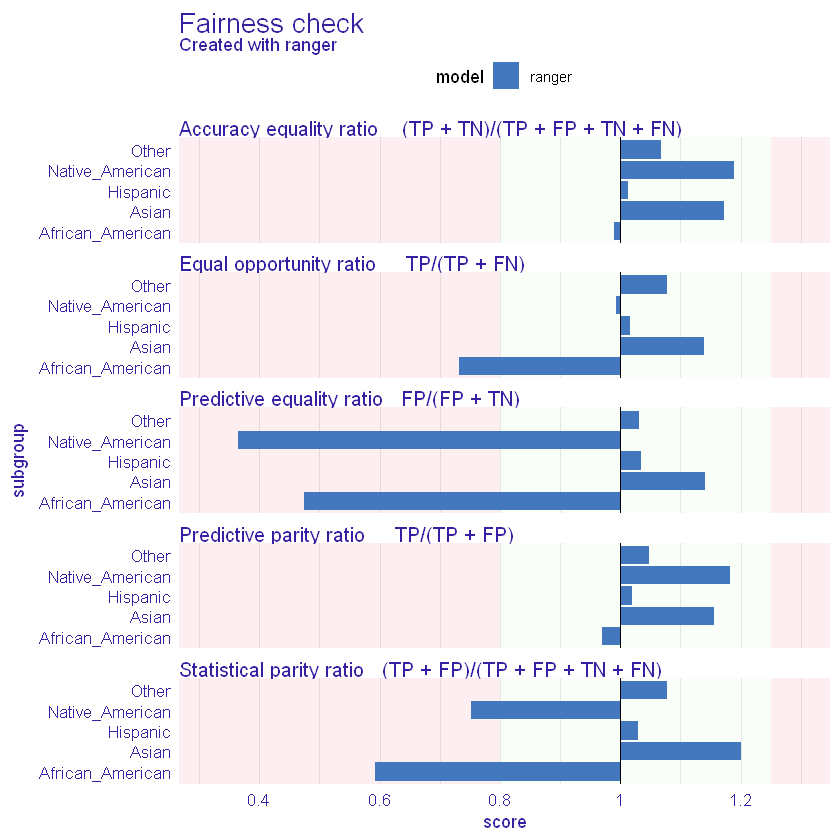

In [7]:
plot(fobject)

Of course the protected parameter can be changed, for example to (here binary) compas$Sex.

In many metrics ranger exceeds fairness threshold (which can be changed by epsilon parameter). If bars reach red field on the left it means that there is bias towards certain unprivileged subgroup. If they reach one on the right it means bias towards privileged (Caucasian - in all metrics here Caucasian subgroup is referenced as base - 1) subgroup. This values mean the proportion (ratio) of certain unprivileged subgroup to privileged subgroup (eg. Asian/Caucasian). By default it represents 80% rule (for eg. women should get credit at rate at least 80% of that of men) . Metrics measure how equal treatment and mistreatment among subgroups is. More on those metrics: wikipedia


Why do we have this bias? Model did learn from biased data. We can see it on plot below

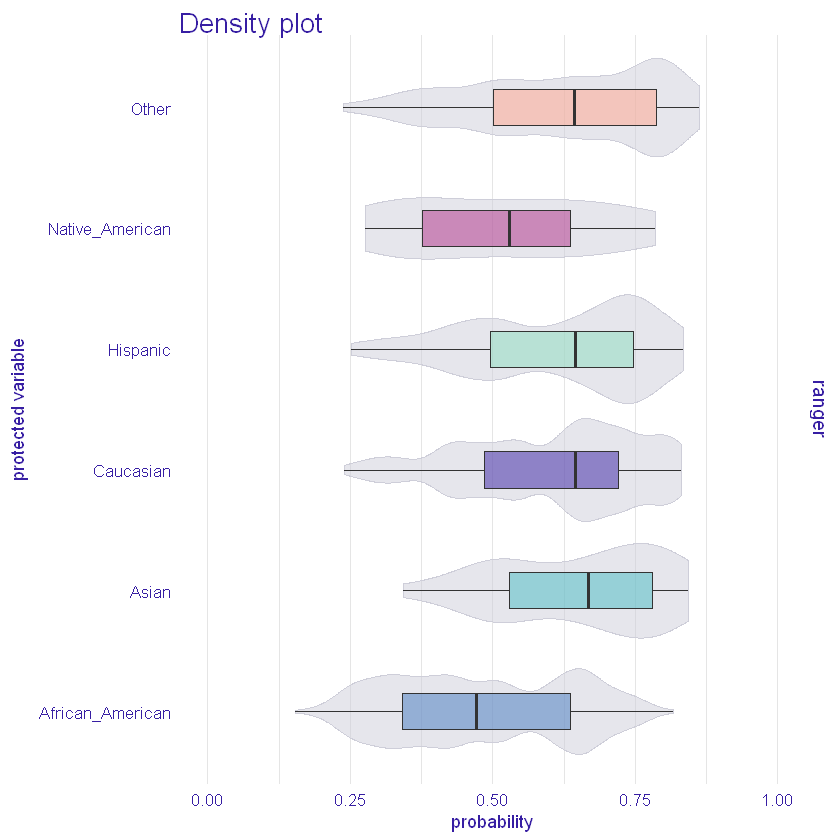

In [8]:
plot_density(fobject)

As we can see it is more likely that model will categorize African Americans as being recidivists than for example Asians.

Sometimes it is worth it to see what the raw (unscaled) metrics are. User could use fobject$groups_data but the easier way is to plot metric_scores object.

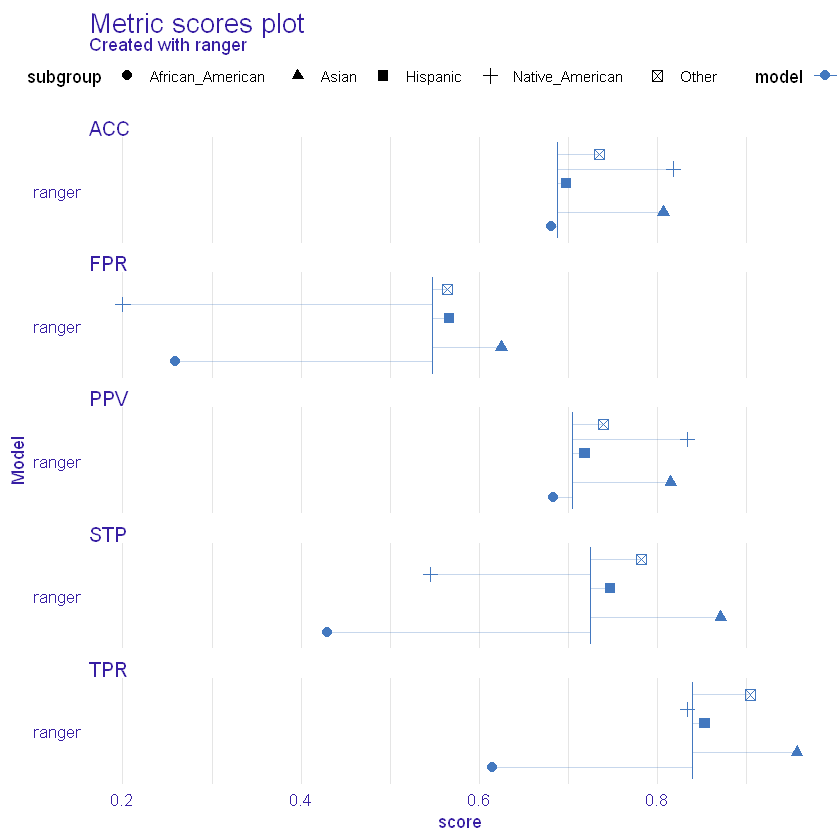

In [9]:
plot(metric_scores(fobject))